# Figure S1, B1, B2 Table S1, S2: Denmark Strait freshwater transport basin timeseries

This notebook will reproduce Figures S1, B1, B2 and Tables S1, S2 from  E. Boland et al. 2026 (doi to come). This requires input datafiles from the ECCOv4 solution and perturbation simulations based on the ECCOv4 solution to run - please see the README for details.

The datafiles were created as follows:
- horflux_fw_denm_adjsens_basin_tseries_vlag.nc was created by running calc_sens_tseries_vslag.py
- horflux_fw_denm_contr_tseries_*.nc were created by running calc_constr_tseries.py
- horflux_fw_denm_cumev_bylag_bybasin_bymonth_*.nc were created by running calc_ev.py
- recon_evstats.nc and recon_correlationstats.nc were created by running calc_recon_stats.py

Please attribute any plots or code from this notebook using the DOI from Zenodo: https://doi.org/10.5281/zenodo.17225514

E Boland Jan 2026 [emmomp@bas.ac.uk](email:emmomp@bas.ac.uk)

In [1]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
%matplotlib inline
import cmasher as cmr
import utils as ut
from scipy import signal, stats
import glob
from inputs import *
import warnings
warnings.filterwarnings('ignore')

In [4]:
masks_plot=['global','gland','natl','arct','norw']
mths_a=['Mar','Jun','Sep','Dec']
mths_b=mth

In [5]:
def preproc(ds):
    ds=ds.interp(lag_years=np.arange(-5,0,0.025))
    return ds

In [6]:
ds_tseries_all=xr.open_dataset('../data_out/horflux_fw_denm_adjsens_basin_tseries_vlag.nc')
dJ_all=[]
for eyear in eyears:
    print(eyear)
    foo=xr.open_mfdataset(f'{CONTR_DIR}/{eyear}/horflux_fw_denm_contr_tseries_*.nc',combine='nested',concat_dim='exp',preprocess=preproc)
    dJ_all.append(foo.assign_coords({'eyear':eyear}).swap_dims({'exp':'month'}).drop_vars(['exp']))
dJ_all=xr.concat(dJ_all,'eyear',coords='minimal',compat='override')

2006
2014
2000


In [7]:
def preproc(ds):
    eyear=ds.encoding['source'].split('_')[-1][:4]
    ds=ds.interp(lag_years=np.arange(-5,0,0.025))
    return ds.assign_coords({'eyear':eyear})
cum_ev=xr.open_mfdataset(f"{EV_DIR}/????/{FCNAME}_cumev_bylag_bybasin_bymonth_*.nc",combine='nested',concat_dim='eyear',preprocess=preproc)

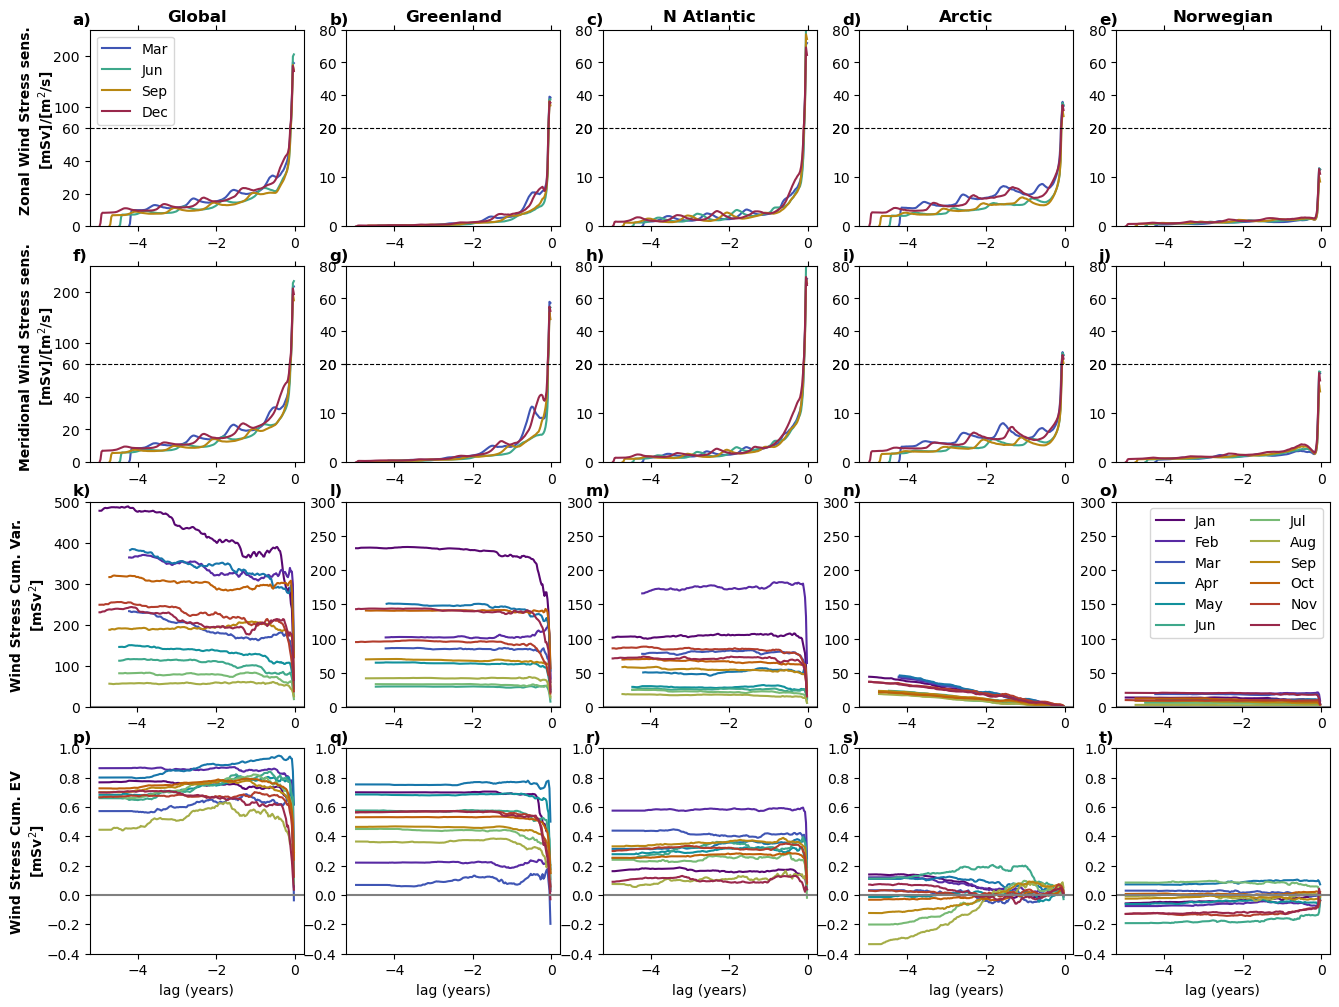

In [12]:
fig=plt.figure(figsize=[16,12])
gs = GridSpec(8,5)
ip=1

colormap = cmr.take_cmap_colors('cmr.infinity', 12,cmap_range=(0,0.85))
upper_lim_global=[60,250]
lower_lim_global=[0,60]
upper_lim_basin=[20,80]
lower_lim_basin=[0,20]

for iv,var in enumerate(['adxx_tauu','adxx_tauv']):
    for ib,basin in enumerate(masks_plot):
        ax1=fig.add_subplot(gs[iv*2,ib])
        ax2=fig.add_subplot(gs[iv*2+1,ib])
        ax2.sharex(ax1)
        pp=[]
        for im,mth in enumerate(mths_a):
            pp.append(((1e-3*ds_tseries_all[var]).sel(stat='abssum',mask=basin,month=mth).mean('eyear').plot(ax=ax1,x='lag_years',add_legend=False,color=colormap[mthi[mth]-1]))[0])
            (1e-3*ds_tseries_all[var]).sel(stat='abssum',mask=basin,month=mth).mean('eyear').plot(ax=ax2,x='lag_years',add_legend=False,color=colormap[mthi[mth]-1])
        if ib ==0:
            ax1.set_ylim(upper_lim_global)
            ax2.set_ylim(lower_lim_global)
            ax2.set_ylabel(f'{adj_labels[var]} sens.\n[mSv]/[{adj_units[var]}]',fontweight='bold',y=1.08)
            if iv==0:
                ax1.legend(pp,mths_a)               
        else:
            ax1.set_ylim(upper_lim_basin)
            ax2.set_ylim(lower_lim_basin)
            ax2.set_ylabel('')
        if iv==0:
            ax1.set_title(masks_labels[basin],fontweight='bold')
        else:
            ax1.set_title('')
        ax2.set_title('')
        ax1.set_ylabel('')
        ax1.set_xlabel('')
        #plt.axhline(0,color='grey')
        ax2.set_xlabel('')        
        ax1.spines.bottom.set_visible(False)
        ax2.spines.top.set_linestyle('dashed')        
        ax2.spines.top.set_capstyle('butt')
        ax1.xaxis.tick_top()
        ax1.tick_params(labeltop=False) 
        ax2.xaxis.tick_bottom()
        l, b, w, h = ax2.get_position().bounds
        ax2.set_position([l,b+0.2*h,w,h])
        plt.text(-0.08,1.05,f'{chr(96+ip)})',transform=ax1.transAxes,fontsize=12,fontweight='bold')
        ip+=1
                              
for ib,basin in enumerate(masks_plot):
    ax=fig.add_subplot(gs[4:6,ib])
    pp=[]
    for im,mth in enumerate(mths_b):
        pp.append(((1e-3*dJ_all['wind_OCE']).sel(stat='sum',mask=basin,month=mthi[mth],year=slice(1996,None)).var('year').mean('eyear').dropna('lag_years')[1:].plot(ax=ax,x='lag_years',add_legend=False,color=colormap[im]))[0])
    if ib ==0:
        plt.ylabel(f'Wind Stress Cum. Var.\n[mSv$^2$]',fontweight='bold')
        plt.ylim([0,500])           
    else:
        plt.ylim([0,300])
        plt.ylabel('')
    if ib==len(masks_plot)-1:
        plt.legend(pp,mths_b,ncol=2)  
    plt.title('')
    plt.axhline(0,color='grey')
    plt.xlabel('')
    plt.text(-0.08,1.03,f'{chr(96+ip)})',transform=plt.gca().transAxes,fontsize=12,fontweight='bold')
    l, b, w, h = ax.get_position().bounds
    ax.set_position([l,b+0.05*h,w,0.95*h])
    ip+=1

for ib,basin in enumerate(masks_plot):
    ax=fig.add_subplot(gs[6:,ib])
    pp=[]
    for im,mth in enumerate(mths_b):
        pp.append((cum_ev['wind_OCE'].sel(mask=basin,month=mthi[mth]).mean('eyear').plot(ax=ax,x='lag_years',add_legend=False,color=colormap[im]))[0])
    if ib ==0:
        plt.ylabel(f'Wind Stress Cum. EV\n[mSv$^2$]',fontweight='bold',labelpad=-1)
    else:
        plt.ylabel('')
    plt.ylim([-0.4,1.0])
    plt.title('')
    plt.axhline(0,color='grey')
    plt.xlabel('lag (years)')
    plt.text(-0.08,1.03,f'{chr(96+ip)})',transform=plt.gca().transAxes,fontsize=12,fontweight='bold')
    l, b, w, h = ax.get_position().bounds
    ax.set_position([l,b,w,0.95*h])
    ip+=1
        
plt.tight_layout()
plt.savefig('../plots/figS1_WindStress_basinTseries.pdf')

In [8]:
var_list=ecco_convs+['wind_OCE','all_OCE']
conv_var_list=[x.removesuffix('_sum') for x in var_list]

dJopt_all=[]
dJful_all=[]
for eyear in eyears:
    print(eyear)
    files=glob.glob(f'{CONTR_DIR}/{eyear}/horflux_fw_denm_contr_tseries_*.nc')
    cum_ev = xr.open_dataset(
        f"{EV_DIR}/{eyear}/horflux_fw_denm_cumev_bylag_byvar_{eyear}.nc"
    )
    cum_ev_bym = xr.open_dataset(
        f"{EV_DIR}/{eyear}/horflux_fw_denm_cumev_bylag_byvar_bymonth_{eyear}.nc"
    )
    cum_ev_bym["lag_years"] = cum_ev["lag_years"]
    lagmax = cum_ev_bym.idxmax("lag_years").squeeze().load()
    dJopt_year=[]
    dJful_year=[]
    for file in files:
        foo=xr.open_dataset(file).sel(stat='sum').squeeze()
        dJ_var=[]
        for var in var_list:
            lmax=lagmax[var].sel(month=foo.month)
            dJ_var.append(foo[var.removesuffix('_sum')].sel(lag_years=lmax, method="nearest").swap_dims({'year':'dates'}))
        dJ_var=xr.merge(dJ_var,compat='override')   
        dJopt_year.append(dJ_var)
        dJful_year.append(foo[conv_var_list].isel(lag_years=-1).swap_dims({'year':'dates'}))
    dJopt_year=xr.concat(dJopt_year,'dates').sortby('dates').assign_coords({'eyear':eyear})
    dJful_year=xr.concat(dJful_year,'dates').sortby('dates').assign_coords({'eyear':eyear})
    dJopt_all.append(dJopt_year)
    dJful_all.append(dJful_year)
dJopt_all=xr.concat(dJopt_all,'eyear',coords='minimal',compat='override')
dJful_all=xr.concat(dJful_all,'eyear',coords='minimal',compat='override')
dJful_all

2006
2014
2000


<xarray.Dataset> Size: 462kB
Dimensions:              (eyear: 3, mask: 11, dates: 264)
Coordinates: (12/17)
    transp               <U2 8B 'fw'
    month                (dates) int64 2kB 1 2 3 4 5 6 7 8 ... 6 7 8 9 10 11 12
    TRANSP               <U2 8B 'fw'
    exp                  (dates) <U27 29kB 'transfw_Jan_fromDec_7d_2006' ... ...
  * dates                (dates) datetime64[ns] 2kB 1996-01-16 ... 2017-12-16
    year                 (dates) int64 2kB 1996 1996 1996 ... 2017 2017 2017
    ...                   ...
    Z                    float32 4B -5.0
    drF                  float32 4B 10.0
    PHrefC               float32 4B 49.05
    stat                 <U6 24B 'sum'
  * mask                 (mask) <U7 308B 'global' 'arct' ... 'gland' 'norw'
  * eyear                (eyear) <U4 48B '2006' '2014' '2000'
Data variables:
    adxx_qnetXoceQnet    (eyear, mask, dates) float64 70kB 3.703e+03 ... 2.05...
    adxx_tauuXoceTAUU    (eyear, mask, dates) float64 70kB 2.22e+03 ... -39.37
    adxx_tauvXoceTAUV    (eyear, mask, dates) float64 70kB 1.074e+03 ... 1.01...
    adxx_empmrXoceFWflx  (eyear, mask, dates) float64 70kB -19.62 ... 1.03
    wind_OCE             (eyear, mask, dates) float64 70kB 3.294e+03 ... 1.00...
    all_OCE              (eyear, mask, dates) float64 70kB 6.977e+03 ... 1.21...
Attributes:
    contact:     emmomp@bas.ac.uk
    references:  ECCOv4r4 Denmark Strait FW flux basin contributions        f...
    date:        Created on 16/06/2025
    notes:       Data produced by analysis of the ECCOv4r4 global ocean state...

In [9]:
dJ_all_gma=(dJopt_all.sel(mask='global')-dJopt_all.sel(mask='arct')).assign_coords({'mask':'global-arct'})
dJopt_all=xr.concat([dJopt_all,dJ_all_gma],'mask')
dJ_all_gma=(dJful_all.sel(mask='global')-dJful_all.sel(mask='arct')).assign_coords({'mask':'global-arct'})
dJful_all=xr.concat([dJful_all,dJ_all_gma],'mask')

In [10]:
fc=ut.get_soln(FCNAME,DATA_DIR)
fc_climanom,fc_mth=ut.soln_anoms(fc)
XX=fc_climanom
XX_smooth=ut.butter_ufunc(XX,13,'time')
XX_high=XX-XX_smooth

read_llc_to_tiles: full_filename:  ../data_out/m_horflux_fw_denm.0000000129.data


In [2]:
masks_plot=['global','global-arct','gland','natl','arct']

In [12]:
YY_opt=dJopt_all.sel(mask=masks_plot).drop('time')
YY_full=dJful_all.sel(mask=masks_plot).drop('time')
YY_opt_lo=ut.butter_ufunc(YY_opt,13,'dates')
YY_opt_hi=YY_opt-YY_opt_lo

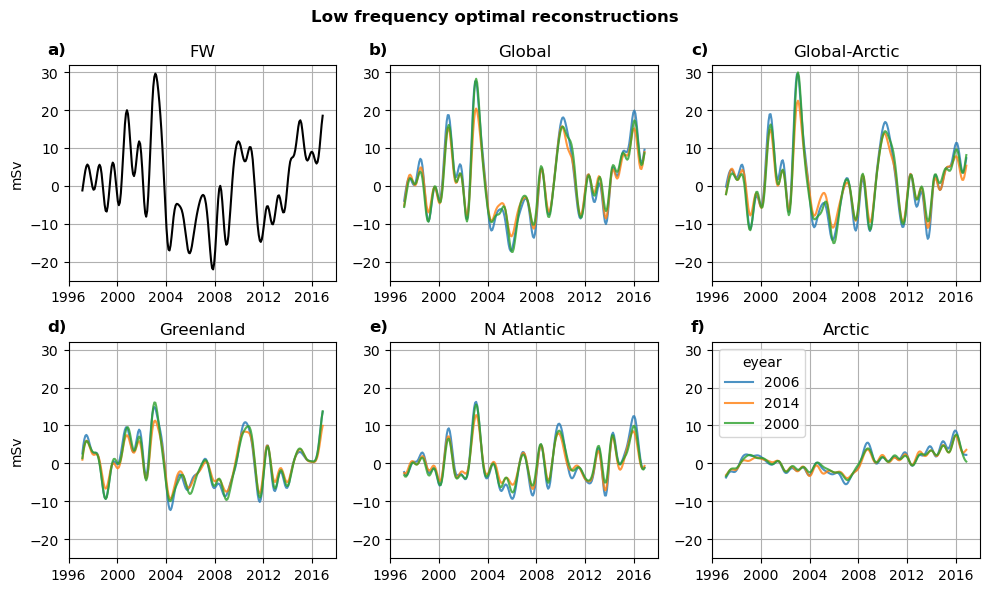

In [14]:
ylims=[-25,32]
xlims=[np.datetime64('1996-01-01'),np.datetime64('2018-01-01')]
labels=['Global','Global-Arctic','Greenland','N Atlantic','Arctic']
mlabels=dict(zip(masks_plot,labels))

plt.figure(figsize=[10,6])
ax=plt.subplot(2,3,1)
(XX_smooth/1e3)[13:-13].plot(x='time',color='k')
plt.title('FW')
plt.ylabel('mSv')
plt.xlabel('')
plt.text(-0.08,1.05,f'a)',transform=ax.transAxes,fontsize=12,fontweight='bold')
plt.ylim(ylims)
plt.xlim(xlims)
ax.grid()
pp=2
for mask in masks_plot:
    ax=plt.subplot(2,3,pp)
    if mask == 'arct':
        (YY_opt_lo.wind_OCE.sel(mask=mask)/1e3)[:,13:-13].plot(x='dates',hue='eyear',alpha=0.8)
    else:
        (YY_opt_lo.wind_OCE.sel(mask=mask)/1e3)[:,13:-13].plot(x='dates',hue='eyear',add_legend=False,alpha=0.8)
    plt.title(mlabels[mask])
    if pp==4:
        plt.ylabel('mSv')
    else:
        plt.ylabel('')
    plt.xlabel('')
    plt.xlim(xlims)
    plt.ylim(ylims)
    plt.text(-0.08,1.05,f'{chr(96+pp)})',transform=ax.transAxes,fontsize=12,fontweight='bold')
    ax.grid()
    pp+=1
plt.suptitle('Low frequency optimal reconstructions',fontweight='bold')
plt.tight_layout()
plt.savefig('../plots/figS6_WindOptLo.pdf')

In [4]:
ev_p_comb=xr.open_dataset('../data_out/recon_evstats.nc')

In [5]:
ev_p_comb

<xarray.Dataset> Size: 3kB
Dimensions:     (recon_type: 4, mask: 5, eyear: 4)
Coordinates:
  * mask        (mask) <U11 220B 'global' 'global-arct' 'gland' 'natl' 'arct'
  * eyear       (eyear) <U8 128B '2006' '2014' '2000' 'ens_mean'
  * recon_type  (recon_type) <U6 96B 'full' 'opt' 'opt_lo' 'opt_hi'
Data variables:
    EV          (recon_type, mask, eyear) float64 640B ...
    EV_lower    (recon_type, mask, eyear) float64 640B ...
    EV_upper    (recon_type, mask, eyear) float64 640B ...
    p           (recon_type, mask, eyear) float64 640B ...

In [6]:
stats_comb=xr.open_dataset('../data_out/recon_correlationstats.nc')
stats_comb

<xarray.Dataset> Size: 4kB
Dimensions:     (recon_type: 4, mask: 5, eyear: 5)
Coordinates:
  * mask        (mask) <U11 220B 'global' 'global-arct' 'gland' 'natl' 'arct'
  * eyear       (eyear) <U8 160B '2006' '2014' '2000' 'combined' 'ens_mean'
  * recon_type  (recon_type) <U6 96B 'full' 'opt' 'opt_lo' 'opt_hi'
Data variables:
    R           (recon_type, mask, eyear) float64 800B ...
    R_up        (recon_type, mask, eyear) float64 800B ...
    R_lo        (recon_type, mask, eyear) float64 800B ...
    p           (recon_type, mask, eyear) float64 800B ...
    p_alt       (recon_type, mask, eyear) float64 800B ...

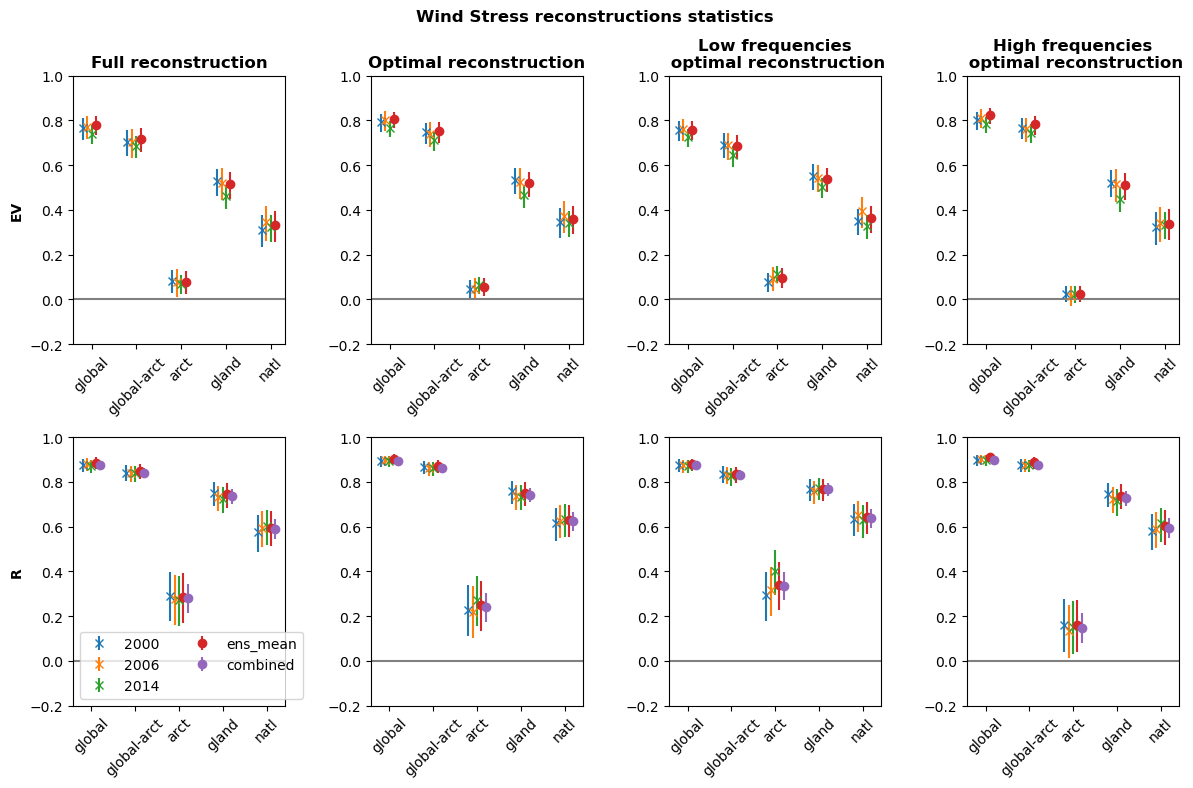

In [7]:
rtypes=['full','opt','opt_lo','opt_hi']
rlabel=['Full','Optimal','Low frequencies\n optimal','High frequencies\n optimal']
masks_plot=['global','global-arct','arct','gland','natl']
plt.figure(figsize=[12,8])
for ir,rtype in enumerate(rtypes):
    plt.subplot(2,4,ir+1)
    for iey,eyear in enumerate(eyears):
        yy=ev_p_comb.EV.sel(eyear=eyear,recon_type=rtype,mask=masks_plot).data
        yerr_up=ev_p_comb.EV_upper.sel(eyear=eyear,recon_type=rtype,mask=masks_plot).data-yy
        yerr_down=yy-ev_p_comb.EV_lower.sel(eyear=eyear,recon_type=rtype,mask=masks_plot).data
        plt.errorbar(np.arange(0,5)-(2-iey)*0.1,yy,[yerr_down,yerr_up],marker='x',ls='',label=eyear)
    for iey,eyear in enumerate(['ens_mean',]):
        yy=ev_p_comb.EV.sel(eyear=eyear,recon_type=rtype,mask=masks_plot).data
        yerr_up=ev_p_comb.EV_upper.sel(eyear=eyear,recon_type=rtype,mask=masks_plot).data-yy
        yerr_down=yy-ev_p_comb.EV_lower.sel(eyear=eyear,recon_type=rtype,mask=masks_plot).data
        plt.errorbar(np.arange(0,5)+(1+iey)*0.1,yy,[yerr_down,yerr_up],marker='o',ls='',label=eyear)  
    plt.xticks(ticks=np.arange(0,5),labels=masks_plot,rotation=45)
    plt.title(f'{rlabel[ir]} reconstruction',fontweight='bold')
    plt.axhline(0,color='grey')
    plt.ylim([-0.2,1])
    if ir==0:
        plt.ylabel('EV',fontweight='bold')
for ir,rtype in enumerate(rtypes):
    plt.subplot(2,4,ir+5)
    for iey,eyear in enumerate(eyears):
        yy=stats_comb.R.sel(eyear=eyear,recon_type=rtype,mask=masks_plot).data
        yerr_up=stats_comb.R_up.sel(eyear=eyear,recon_type=rtype,mask=masks_plot).data-yy
        yerr_down=yy-stats_comb.R_lo.sel(eyear=eyear,recon_type=rtype,mask=masks_plot).data
        plt.errorbar(np.arange(0,5)-(2-iey)*0.1,yy,[yerr_down,yerr_up],marker='x',ls='',label=eyear)
    for iey,eyear in enumerate(['ens_mean','combined']):
        yy=stats_comb.R.sel(eyear=eyear,recon_type=rtype,mask=masks_plot).data
        yerr_up=stats_comb.R_up.sel(eyear=eyear,recon_type=rtype,mask=masks_plot).data-yy
        yerr_down=yy-stats_comb.R_lo.sel(eyear=eyear,recon_type=rtype,mask=masks_plot).data
        plt.errorbar(np.arange(0,5)+(1+iey)*0.1,yy,[yerr_down,yerr_up],marker='o',ls='',label=eyear)  
    plt.xticks(ticks=np.arange(0,5),labels=masks_plot,rotation=45)
    #plt.title(f'{rlabel[ir]} reconstruction',fontweight='bold')
    plt.title('')
    plt.axhline(0,color='grey')
    plt.ylim([-0.2,1])
    #plt.gca().grid('y')
    if ir==0:
        plt.legend(loc='lower left',ncols=2)
        plt.ylabel('R',fontweight='bold')
plt.suptitle('Wind Stress reconstructions statistics',fontweight='bold')
plt.tight_layout()
plt.savefig('../plots/FigB2_WindStats_withCI.pdf')

In [8]:
print(ev_p_comb[['EV','EV_lower','EV_upper','p']].sel(eyear='ens_mean').reset_coords(drop=True).to_dataframe(dim_order=('recon_type', 'mask')).to_latex(float_format="{:2.2f}".format))

\begin{tabular}{llrrrr}
\toprule
 &  & EV & EV_lower & EV_upper & p \\
recon_type & mask &  &  &  &  \\
\midrule
\multirow[t]{5}{*}{full} & global & 0.78 & 0.73 & 0.82 & 0.00 \\
 & global-arct & 0.72 & 0.66 & 0.77 & 0.00 \\
 & gland & 0.51 & 0.45 & 0.57 & 0.00 \\
 & natl & 0.33 & 0.26 & 0.40 & 0.00 \\
 & arct & 0.08 & 0.03 & 0.13 & 0.01 \\
\cline{1-6}
\multirow[t]{5}{*}{opt} & global & 0.81 & 0.77 & 0.84 & 0.00 \\
 & global-arct & 0.75 & 0.70 & 0.79 & 0.00 \\
 & gland & 0.52 & 0.46 & 0.57 & 0.00 \\
 & natl & 0.36 & 0.29 & 0.42 & 0.00 \\
 & arct & 0.06 & 0.02 & 0.10 & 0.01 \\
\cline{1-6}
\multirow[t]{5}{*}{opt_lo} & global & 0.76 & 0.71 & 0.80 & 0.00 \\
 & global-arct & 0.69 & 0.63 & 0.73 & 0.00 \\
 & gland & 0.54 & 0.48 & 0.59 & 0.00 \\
 & natl & 0.36 & 0.30 & 0.42 & 0.00 \\
 & arct & 0.10 & 0.05 & 0.14 & 0.05 \\
\cline{1-6}
\multirow[t]{5}{*}{opt_hi} & global & 0.82 & 0.79 & 0.85 & 0.00 \\
 & global-arct & 0.78 & 0.73 & 0.82 & 0.00 \\
 & gland & 0.51 & 0.44 & 0.57 & 0.00 \\
 & natl & 

In [9]:
print(stats_comb[['R','R_lo','R_up','p_alt']].sel(eyear='combined').reset_coords(drop=True).to_dataframe(dim_order=('recon_type', 'mask')).to_latex(float_format="{:2.2f}".format))

\begin{tabular}{llrrrr}
\toprule
 &  & R & R_lo & R_up & p_alt \\
recon_type & mask &  &  &  &  \\
\midrule
\multirow[t]{5}{*}{full} & global & 0.88 & 0.86 & 0.89 & 0.00 \\
 & global-arct & 0.84 & 0.82 & 0.86 & 0.00 \\
 & gland & 0.74 & 0.70 & 0.77 & 0.00 \\
 & natl & 0.59 & 0.54 & 0.63 & 0.00 \\
 & arct & 0.28 & 0.21 & 0.34 & 0.00 \\
\cline{1-6}
\multirow[t]{5}{*}{opt} & global & 0.89 & 0.88 & 0.91 & 0.00 \\
 & global-arct & 0.86 & 0.84 & 0.88 & 0.00 \\
 & gland & 0.74 & 0.71 & 0.77 & 0.00 \\
 & natl & 0.62 & 0.58 & 0.67 & 0.00 \\
 & arct & 0.24 & 0.17 & 0.30 & 0.00 \\
\cline{1-6}
\multirow[t]{5}{*}{opt_lo} & global & 0.87 & 0.86 & 0.89 & 0.00 \\
 & global-arct & 0.83 & 0.81 & 0.85 & 0.00 \\
 & gland & 0.77 & 0.74 & 0.79 & 0.00 \\
 & natl & 0.64 & 0.59 & 0.68 & 0.00 \\
 & arct & 0.34 & 0.27 & 0.40 & 0.03 \\
\cline{1-6}
\multirow[t]{5}{*}{opt_hi} & global & 0.90 & 0.88 & 0.91 & 0.00 \\
 & global-arct & 0.88 & 0.86 & 0.89 & 0.00 \\
 & gland & 0.73 & 0.69 & 0.76 & 0.00 \\
 & natl & 0.60 